# Import Packages

In [1]:
import random
import gymnasium as gym
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.tensorboard import SummaryWriter  # Import TensorBoard
from itertools import count
from collections import deque

# Action Space

Do nothing = 0

Fire right engine = 1

Fire main engine = 2

Fire left engine = 3

# Observational Space

Consists of a state vector with 8 variables:

- Its **(x,y)** cordinates. The landing pad corresponds to **(0,0)**
- Linear velocities of x and y
- Its angle
- Its angular velocity
- Two booleans that represent whether each leg is in contact with the ground or not.

# Rewards

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least **200 points.**

# Hyperparameters

In [2]:
GAMMA = 0.995
ALPHA = 1e-3
BATCH_SIZE = 64
BUFFER_SIZE = 100000
TARGET_UPDATE_EVERY = 1000
NUM_EPISODES = 1500
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 5000
UPDATE_EVERY = 4

# Environment

The **Experience** named tuple is responsible to help organize the data for each step the agent takes improving its readability and makes it cleaner when training the model.

In [3]:
env = gym.make("LunarLander-v3")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Experience tuple
Experience = namedtuple("Experience", ["state", "action", "reward", "next_state", "done"])


c:\Users\Diogo Rodrigues\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


# Replay Buffer Class

Is responsible to store past experiences to enable experience replay

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def add(self, experience): #Add new experience
        self.memory.append(experience)

    def sample(self, batch_size): #Returns a random mini-batch for training
        batch = random.sample(self.memory, batch_size)
        return map(torch.tensor, zip(*batch))

    def __len__(self):
        return len(self.memory)

# Q-Function

Defines the neural network that approximates the **Q-value Function**
- It takes a state as input and returns Q-Values for each possible action
- Uses two hidden layers with ReLU activations

In [5]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        return self.net(x)

# Select Action

Selects a action using the **epsilon-greedy strategy**. With a probability **epsilon**, choose a random action, otherwise choose the best action according to the policy network.

In [6]:
def select_action(state, epsilon, policy_net):
    if random.random() < epsilon:
        return random.randint(0, action_size - 1)
    else:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            return int(torch.argmax(policy_net(state_tensor)))

# Initialize Network and Optimizer

Initializes the policy and target Q-networks.

The target network is a stabilized copy of the policy net, updated less frequently.

Sets up the Adam optimizer and replay buffer.

In [7]:

policy_net = QNetwork(state_size, action_size)
target_net = QNetwork(state_size, action_size)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=ALPHA)
replay_buffer = ReplayBuffer(BUFFER_SIZE)

# Deep Q-Learning Training Loop

In [8]:
steps = 0
epsilon = EPS_START  # Start with high exploration
episode_rewards = []
epsilon_values = []
convergence_episode = None
reward_threshold = 200

for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = select_action(state, epsilon, policy_net)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        replay_buffer.add(Experience(state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        steps += 1

        if len(replay_buffer) >= BATCH_SIZE and steps % UPDATE_EVERY == 0:
            states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

            states = states.float()
            actions = actions.long()
            rewards = rewards.float()
            next_states = next_states.float()
            dones = dones.float()

            q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

            with torch.no_grad():
                max_next_q = target_net(next_states).max(1)[0]
                target_q = rewards + (GAMMA * max_next_q * (1 - dones))

            loss = nn.MSELoss()(q_values, target_q)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
            optimizer.step()

        if steps % TARGET_UPDATE_EVERY == 0:
            target_net.load_state_dict(policy_net.state_dict())

    episode_rewards.append(total_reward)
    epsilon_values.append(epsilon)

    if len(episode_rewards) >= 100 and convergence_episode is None:
        avg_last_100 = np.mean(episode_rewards[-100:])
        if avg_last_100 >= reward_threshold:
            convergence_episode = episode
            print(f"\n\n[DQN] Environment solved in {episode + 1} episodes!")
            torch.save(policy_net.state_dict(), "lunar_lander_model_DQL.pth")
            break

    epsilon = EPS_END + (EPS_START - EPS_END) * np.exp(-episode / (EPS_DECAY / NUM_EPISODES))

    if episode % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f"[DQN] Episode {episode}, Reward: {total_reward:.2f}, Avg(10): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")

print("[DQN] Training complete.")


C:\Users\Diogo Rodrigues\AppData\Local\Temp\ipykernel_3852\1693447017.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)


[DQN] Episode 0, Reward: -352.76, Avg(10): -352.76, Epsilon: 1.000
[DQN] Episode 10, Reward: -140.76, Avg(10): -281.52, Epsilon: 0.059
[DQN] Episode 20, Reward: -183.23, Avg(10): -176.82, Epsilon: 0.012
[DQN] Episode 30, Reward: -103.69, Avg(10): -165.48, Epsilon: 0.010
[DQN] Episode 40, Reward: -152.14, Avg(10): -147.08, Epsilon: 0.010
[DQN] Episode 50, Reward: -112.24, Avg(10): -70.96, Epsilon: 0.010
[DQN] Episode 60, Reward: -250.09, Avg(10): -50.09, Epsilon: 0.010
[DQN] Episode 70, Reward: -93.11, Avg(10): -61.89, Epsilon: 0.010
[DQN] Episode 80, Reward: -16.25, Avg(10): -67.12, Epsilon: 0.010
[DQN] Episode 90, Reward: -50.83, Avg(10): -36.12, Epsilon: 0.010
[DQN] Episode 100, Reward: 184.65, Avg(10): 18.02, Epsilon: 0.010
[DQN] Episode 110, Reward: -120.56, Avg(10): -34.21, Epsilon: 0.010
[DQN] Episode 120, Reward: -48.27, Avg(10): 27.37, Epsilon: 0.010
[DQN] Episode 130, Reward: 215.64, Avg(10): 138.74, Epsilon: 0.010
[DQN] Episode 140, Reward: 200.47, Avg(10): 155.26, Epsilon: 0

# SARSA Implementation

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque

# Define the neural network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        return self.layers(x)

# Define SARSA agent
class SARSAAgent:
    def __init__(self, state_size, action_size, gamma=0.99, alpha=1e-3, buffer_size=10000, batch_size=64, tau=1000):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.alpha = alpha
        self.batch_size = batch_size
        self.tau = tau  # sync interval

        self.policy_net = QNetwork(state_size, action_size)
        self.target_net = QNetwork(state_size, action_size)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.alpha)
        self.memory = deque(maxlen=buffer_size)
        self.steps = 0

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return self.policy_net(state_tensor).argmax().item()

    def step(self, state, action, reward, next_state, next_action, done):
        self.memory.append((state, action, reward, next_state, next_action, done))
        self.steps += 1

        if len(self.memory) >= self.batch_size:
            self.learn()

        if self.steps % self.tau == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def learn(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, next_actions, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        next_actions = torch.LongTensor(next_actions).unsqueeze(1)
        dones = torch.BoolTensor(dones)

        current_q = self.policy_net(states).gather(1, actions).squeeze()
        next_q = self.target_net(next_states).gather(1, next_actions).squeeze()
        targets = rewards + self.gamma * next_q * (~dones)

        loss = F.mse_loss(current_q, targets.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, env, episodes=3000, eps_start=1.0, eps_end=0.01, eps_decay=2500):
        epsilon = eps_start
        decay_rate = (eps_start - eps_end) / eps_decay
        rewards = []
        self.epsilon_log = []

        for episode in range(1, episodes + 1):
            state, _ = env.reset()
            action = self.select_action(state, epsilon)
            done = False
            total_reward = 0

            while not done:
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                next_action = self.select_action(next_state, epsilon)
                self.step(state, action, reward, next_state, next_action, done)
                state, action = next_state, next_action
                total_reward += reward

            epsilon = max(eps_end, epsilon - decay_rate)
            self.epsilon_log.append(epsilon)
            rewards.append(total_reward)

            if episode % 100 == 0:
                print(f"[SARSA] Episode {episode} | Reward: {total_reward:.2f}")

            if len(rewards) >= 100:
                av_latest_points = np.mean(rewards[-100:])
                if av_latest_points >= 200.0:
                    print(f"\n\n[SARSA] Environment solved in {episode} episodes!")
                    torch.save(self.policy_net.state_dict(), "lunar_lander_model_SARSA.pth")
                    break

        return rewards


In [10]:
env = gym.make("LunarLander-v3")  # or v3 if that's what you're using
agent = SARSAAgent(env.observation_space.shape[0], env.action_space.n)
reward_log = agent.train(env)

[SARSA] Episode 100 | Reward: -309.68
[SARSA] Episode 200 | Reward: -142.38
[SARSA] Episode 300 | Reward: -95.02
[SARSA] Episode 400 | Reward: -149.91
[SARSA] Episode 500 | Reward: -124.49
[SARSA] Episode 600 | Reward: -56.25
[SARSA] Episode 700 | Reward: -68.77
[SARSA] Episode 800 | Reward: -64.73
[SARSA] Episode 900 | Reward: -74.86
[SARSA] Episode 1000 | Reward: -71.57
[SARSA] Episode 1100 | Reward: -2.41
[SARSA] Episode 1200 | Reward: -9.14
[SARSA] Episode 1300 | Reward: 40.34
[SARSA] Episode 1400 | Reward: -21.81
[SARSA] Episode 1500 | Reward: 23.19
[SARSA] Episode 1600 | Reward: 98.59
[SARSA] Episode 1700 | Reward: -30.62
[SARSA] Episode 1800 | Reward: 0.20
[SARSA] Episode 1900 | Reward: 236.73
[SARSA] Episode 2000 | Reward: 244.45
[SARSA] Episode 2100 | Reward: 3.55
[SARSA] Episode 2200 | Reward: 290.24
[SARSA] Episode 2300 | Reward: 237.21
[SARSA] Episode 2400 | Reward: 45.99


[SARSA] Environment solved in 2453 episodes!


# Training Performance

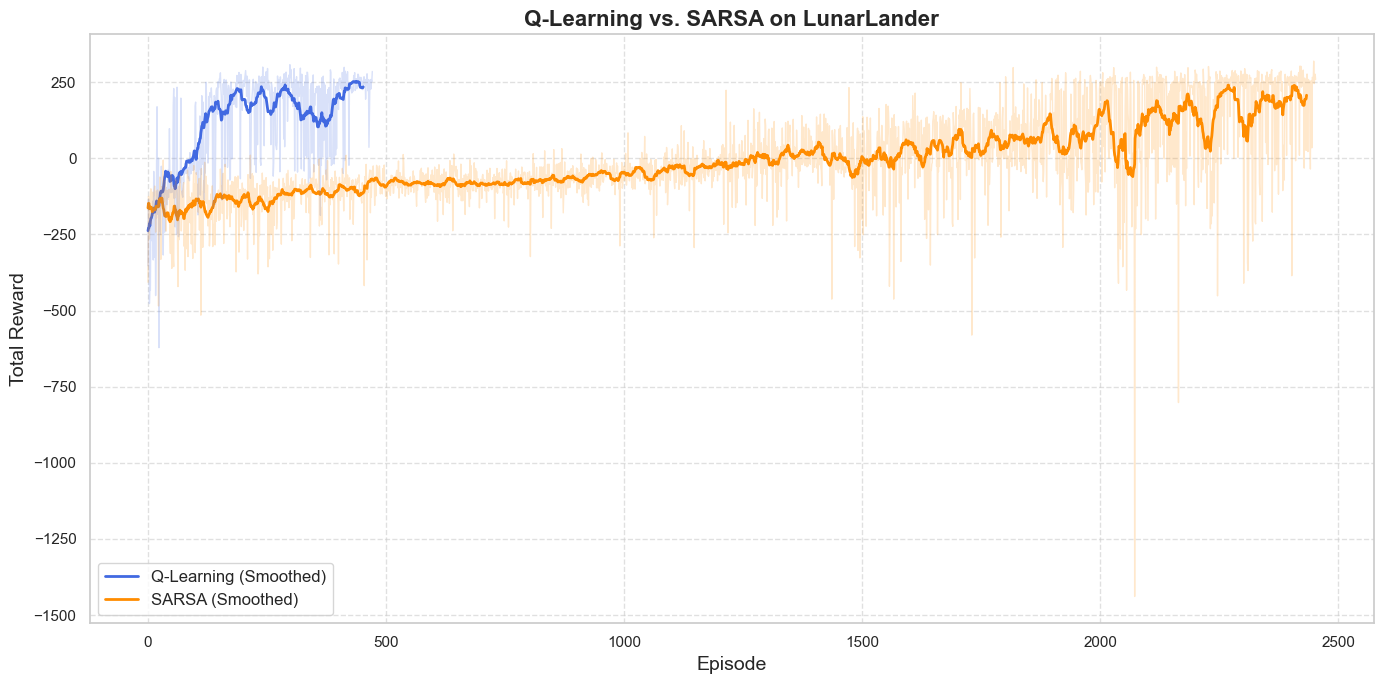

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")


# Apply moving average to smooth the curves (adjust window size as needed)
def moving_average(data, window_size=20):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


plt.figure(figsize=(14, 7))
plt.plot(moving_average(episode_rewards), label='Q-Learning (Smoothed)', color='royalblue', linewidth=2)
plt.plot(moving_average(reward_log), label='SARSA (Smoothed)', color='darkorange', linewidth=2)


plt.plot(episode_rewards, color='royalblue', alpha=0.2, linewidth=1)
plt.plot(reward_log, color='darkorange', alpha=0.2, linewidth=1)


plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)
plt.title("Q-Learning vs. SARSA on LunarLander", fontsize=16, fontweight='bold')

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


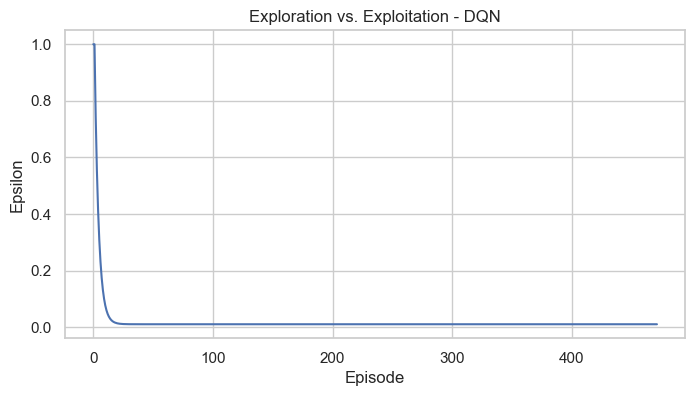

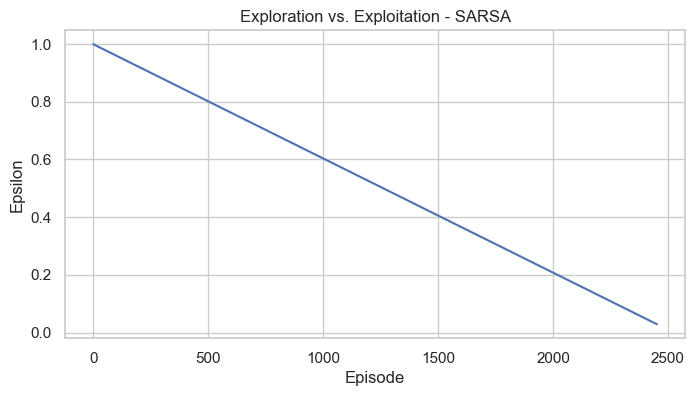

In [13]:
def plot_epsilon_decay(epsilon_values, label='Agent'):
    plt.figure(figsize=(8, 4))
    plt.plot(epsilon_values)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title(f'Exploration vs. Exploitation - {label}')
    plt.grid(True)
    plt.show()

plot_epsilon_decay(epsilon_values, label='DQN')
plot_epsilon_decay(agent.epsilon_log, label='SARSA')
